# Dr Ds Idiots Guide to Spatial Interaction Modelling for Dummies -  Part 2b: Constrained Models - doubly constrained

## Recap

Last workshop we built on our knowledge of unconstrained models by introducing the two singly constrained models. Within these models, more information can be added in, if it is available, in order to improve model fit and we covered some potential use cases. We could see that by adding constraints in the model, using information that we already had, could improve how well the model is able to model flows between boroughs but also we could choose the model depending on the what behaviour or values we would like to change to see how it would in theory affect flows.

This week we will build on that by introducing the doubly constrained model which contains as much information as possible into the model. Before that however we need to bring in the data from the first practical so taht we can use it to cmopare the results of the new practical:

In [1]:
#import the necessary libraries 
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import folium
import statsmodels.api as sm
import scipy.stats
import numpy as np
from math import sqrt
import statsmodels.formula.api as smf

In [2]:
#set up the metric calculations
def CalcRSqaured(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

In [3]:
#read in the cdatasub from the first week
cdatasub = pd.read_csv("Data/cdatasub1.csv", index_col=0)

In [4]:
#show the actual flows between boroughs
cdatasubmat = pd.pivot_table(cdatasub, values ="TotalNoIntra", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)
#show the data
cdatasubmat

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,194.0,96.0,178.0,66.0,1500.0,3641.0,5675
Barnet,96.0,NaN,34.0,5467.0,76.0,12080.0,7709.0,25462
Bexley,362.0,132.0,NaN,144.0,4998.0,2470.0,6580.0,14686
Brent,40.0,6124.0,28.0,NaN,66.0,8105.0,4145.0,18508
Bromley,134.0,162.0,3199.0,201.0,NaN,3780.0,9855.0,17331
Camden,36.0,1496.0,32.0,1350.0,60.0,NaN,8795.0,11769
City of London,6.0,14.0,0.0,16.0,0.0,335.0,NaN,371
All,674.0,8122.0,3389.0,7356.0,5266.0,28270.0,40725.0,93802



3. We might be interested in understanding the changing patterns of commuting or migration over time. Data from the Census allows us to know an accurate snap-shot of migrating and commuting patterns every 10 years. In these full data matrices, we know both the numbers of commuters/migrants leaving origins and arriving at destinations as well as the interactions between them. If we constrain our model estimates to this known information at origin and destination, we can examine various things, including:
    - The ways that the patterns of commuting/migration differ from the model predictions - where we might get more migrant/commuter flows than we would expect
    - How the model parameters vary over time - for example how does distance / cost of travel affect flows over time? Are people prepared to travel further or less far than before?

## 4. Doubly Constrained Model

For the doubly constrained model:

- We might be interested in understanding the changing patterns of commuting or migration over time. Data from the Census allows us to know an accurate snap-shot of migrating and commuting patterns every 10 years. In these full data matrices, we know both the numbers of commuters/migrants leaving origins and arriving at destinations as well as the interactions between them. If we constrain our model estimates to this known information at origin and destination, we can examine various things, including:
    - The ways that the patterns of commuting/migration differ from the model predictions - where we might get more migrant/commuter flows than we would expect
    - How the model parameters vary over time - for example how does distance / cost of travel affect flows over time? Are people prepared to travel further or less far than before?


Which we can now introduce.

Lets begin with the formula:

\begin{equation} \tag{9}
T_{ij} = A_i B_j O_i D_j d_{ij}^{-\beta}
\end{equation}

Where

\begin{equation} \tag{10}
O_i = \sum_j T_{ij}
\end{equation}

\begin{equation} \tag{11}
D_j = \sum_i T_{ij} 
\end{equation}

and

\begin{equation} \tag{12}
A_i = \frac{1}{\sum_j B_j D_j d_{ij}^{-\beta}}
\end{equation}

\begin{equation} \tag{13}
B_j = \frac{1}{\sum_i A_i O_i d_{ij}^{-\beta}}
\end{equation}

Now, the astute will have noticed that the calculation of $A_i$ relies on knowing $B_j$ and the calculation of $B_j$ relies on knowing $A_i$. A conundrum!! If I don’t know $A_i$ how can I calcuate $B_j$ and then in turn $A_i$ and then $B_j$ ad infinitum???!!

Well, I wrestled with that for a while until I came across [this paper by Martyn Senior](http://journals.sagepub.com/doi/abs/10.1177/030913257900300218) where he sketches out a very useful algorithm for iteratively arriving at values for $A_i$ and $B_j$ by setting each to eqaul 1 initially and then continuing to calculate each in turn until the difference between each value is small enough not to matter.

We will return to this later, but for now, we will once again used the awesome power of Python to deal with all this difficulty for us!

We can run the doubly constrained model in exactly the same way as we ran the singly constrained models:

\begin{equation} \tag{14}
\lambda_{ij} = \exp (\alpha_i + \gamma_i -\beta \ln d_{ij})
\end{equation}

now in python:

In [5]:
#create the formula (the "-1" indicates no intercept in the regression model).
dbl_form = 'Total ~ Dest + Orig + log_Dist - 1'
#run a production constrained sim
doubSim = smf.glm(formula = dbl_form, data=cdatasub, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(doubSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Total   No. Observations:                   42
Model:                            GLM   Df Residuals:                       28
Model Family:                 Poisson   Df Model:                           13
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2960.8
Date:                Fri, 04 Feb 2022   Deviance:                       5607.1
Time:                        10:12:55   Pearson chi2:                 4.88e+03
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Dest[Barking and Dag

And the various flows and goodness-of-fit statistics?

In [6]:
#get the estimates
cdatasub["doubsimfitted"] = np.round(doubSim.mu)
#here's the matrix
cdatasubmat7 = cdatasub.pivot_table(values ="doubsimfitted", index="Orig", columns = "Dest",
                                    aggfunc=np.sum, margins=True)
cdatasubmat7

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,309.0,849.0,135.0,420.0,969.0,2993.0,5675.0
Barnet,23.0,NaN,72.0,5533.0,194.0,12970.0,6669.0,25461.0
Bexley,500.0,561.0,NaN,303.0,4454.0,1991.0,6876.0,14685.0
Brent,10.0,5275.0,37.0,NaN,125.0,8885.0,4176.0,18508.0
Bromley,134.0,818.0,2406.0,553.0,NaN,3127.0,10294.0,17332.0
Camden,6.0,1140.0,22.0,819.0,65.0,NaN,9716.0,11768.0
City of London,1.0,20.0,3.0,13.0,7.0,328.0,NaN,372.0
All,674.0,8123.0,3389.0,7356.0,5265.0,28270.0,40724.0,93801.0


compared to...

In [7]:
cdatasubmat

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,194.0,96.0,178.0,66.0,1500.0,3641.0,5675
Barnet,96.0,NaN,34.0,5467.0,76.0,12080.0,7709.0,25462
Bexley,362.0,132.0,NaN,144.0,4998.0,2470.0,6580.0,14686
Brent,40.0,6124.0,28.0,NaN,66.0,8105.0,4145.0,18508
Bromley,134.0,162.0,3199.0,201.0,NaN,3780.0,9855.0,17331
Camden,36.0,1496.0,32.0,1350.0,60.0,NaN,8795.0,11769
City of London,6.0,14.0,0.0,16.0,0.0,335.0,NaN,371
All,674.0,8122.0,3389.0,7356.0,5266.0,28270.0,40725.0,93802


and we can test the goodness-of-fit ine xactly the same was as before:

In [8]:
CalcRSqaured(cdatasub["Total"],cdatasub["doubsimfitted"])

0.9815831216143096

In [9]:
CalcRMSE(cdatasub["Total"],cdatasub["doubsimfitted"])

451.04

So the goodness of fit has shot up and we can clearly see the origin and destination constraints working, and for most sets of flows, the mdoel is now producing some good estimates. However, there are still some errors in the flows, particulalry for estimates between Barking and Dagenham and Bexley or Barnet and Camden.

Is there anything more we can do? Yes, of course there is.

## 4.1 Tweaking our model

### 4.1.1 Distance Decay

Now, all of the way through these practicals, we have assumed that the distance decay parameter follows a negative power law. Well, it doesn't need to.

In [Wilson's original paper](http://journals.sagepub.com/doi/abs/10.1068/a030001) he generalised the distance decay parameter to:

\begin{equation} \tag{15}
f(d_{ij})
\end{equation}

Where $f$ represents some function of distance describing the rate at which the flow interactions change as distance icnreas. Lots of people have written about this, including [Talyor](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1538-4632.1971.tb00364.x) and more recently Robin Lovelace in a transport context, [here](https://www.slideshare.net/ITSLeeds/estimating-distance-decay-for-the-national-propensity-to-cycle-tool).

For the inverse power law that we have been using one pussible function of distance, the other common one that is used is the negative exponential function:

\begin{equation} \tag{16}
\exp (-\beta d_{ij})
\end{equation}

We can get a feel for how different distance decay parameters work by plotting some sample data (try different parameters):

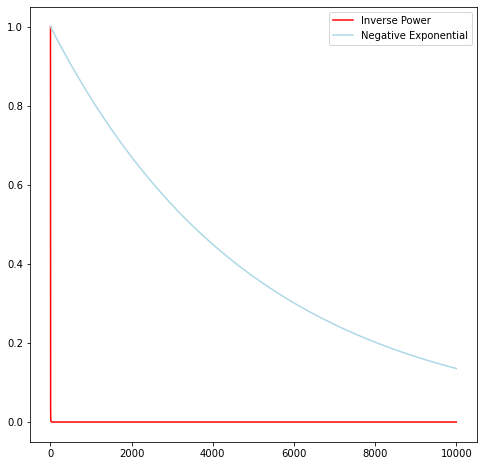

In [10]:
# Now let's consider some model tweaks.
# Starting with distance decay.
# Let's graph so distance decay parameters to get a feel for how they work.
xs = np.arange(1.0,10000.0,0.25)
# inverse square power
y_inv_power = np.power(xs,-2.4945)
# negative exponential, beta = 0.3
y_neg_exp_point3 = np.exp(-0.0002*xs)

# Now a plot.
f, ax = plt.subplots(figsize=(8,8))
ax.plot(xs,y_inv_power, label = "Inverse Power", color = "red")
ax.plot(xs,y_neg_exp_point3, label = 'Negative Exponential', color = "lightblue")
ax.legend();

With these parameters, the inverse power function has a far more rapid distance decay effect than the negative exponential function. In real life, what this means is that if the observed interactions drop off very rapidly with distance, then they might be more likely to follow an inverse power law. This might be the case when looking at trips to the local convenience store by walking, for example. On the other hand, if the effect of distance is less severe (for example migration across the country for a new job) then the negative exponential funtion might be more appropriate.

There is no hard and fast rule as to which function to pick, it will just come down to which fits the data better…

As [Taylor Oshan points out in his excellent Primer](http://openjournals.wu.ac.at/region/paper_175/175.html) what this means in our Poisson regression model is that we simply substitute $-\beta \ln d_{ij}$ for $-\beta d_{ij}$ in our model:

In [11]:
# Run a production constrained SIM with a negative exponential cost function.
doubsim_form = "Total ~ Orig + Dest + Dist -1"
doubsim1 = smf.glm(formula=doubsim_form, data = cdatasub, family = sm.families.Poisson()).fit()
print(doubsim1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Total   No. Observations:                   42
Model:                            GLM   Df Residuals:                       28
Model Family:                 Poisson   Df Model:                           13
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1956.8
Date:                Fri, 04 Feb 2022   Deviance:                       3599.1
Time:                        10:12:55   Pearson chi2:                 3.42e+03
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Orig[Barking and Dag

In [12]:
cdatasub["doubsimfitted1"] = np.round(doubsim1.mu,0)

In [13]:

#here's the matrix
cdatasubmat8 = cdatasub.pivot_table(values ="doubsimfitted1", index="Orig", columns = "Dest",
                                    aggfunc=np.sum, margins=True)
cdatasubmat8

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,261.0,713.0,98.0,387.0,1110.0,3106.0,5675.0
Barnet,17.0,NaN,31.0,5274.0,66.0,13108.0,6967.0,25463.0
Bexley,490.0,324.0,NaN,178.0,4664.0,1986.0,7043.0,14685.0
Brent,6.0,5052.0,16.0,NaN,57.0,8719.0,4658.0,18508.0
Bromley,148.0,392.0,2597.0,353.0,NaN,3057.0,10784.0,17331.0
Camden,11.0,2054.0,29.0,1426.0,81.0,NaN,8168.0,11769.0
City of London,1.0,39.0,4.0,27.0,10.0,290.0,NaN,371.0
All,673.0,8122.0,3390.0,7356.0,5265.0,28270.0,40726.0,93802.0


In [14]:
cdatasubmat

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,194.0,96.0,178.0,66.0,1500.0,3641.0,5675
Barnet,96.0,NaN,34.0,5467.0,76.0,12080.0,7709.0,25462
Bexley,362.0,132.0,NaN,144.0,4998.0,2470.0,6580.0,14686
Brent,40.0,6124.0,28.0,NaN,66.0,8105.0,4145.0,18508
Bromley,134.0,162.0,3199.0,201.0,NaN,3780.0,9855.0,17331
Camden,36.0,1496.0,32.0,1350.0,60.0,NaN,8795.0,11769
City of London,6.0,14.0,0.0,16.0,0.0,335.0,NaN,371
All,674.0,8122.0,3389.0,7356.0,5266.0,28270.0,40725.0,93802


In [15]:
CalcRSqaured(cdatasub["Total"],cdatasub["doubsimfitted1"])

0.9835321475412178

In [16]:

CalcRMSE(cdatasub["Total"],cdatasub["doubsimfitted1"])

423.361

So we can see that using a negative exponential in our model actually improves the fit and reduces the RMSE score.

### 4.1.2 Bunging some more variables in

Yes, the nice thing about doing all of this in a regression modelling framework is we can just keep adding rpedictor variables into the mix and seeing whether they have an effect.

You can't add origin or destination specific predictors into a doubly constrained model like this (To see why see the paper by [Flowerdew and Lovett 1988](https://onlinelibrary.wiley.com/doi/pdf/10.1111/j.1538-4632.1988.tb00184.x)) however, you could add some interaction predictors. For example, instead of modelling total flows, we could try and mdoel motorbike commuters using information on car and underground commuters:

In [17]:
KitchenSinkForm = "Motobike ~ Orig + Dest + Dist +CarDrive +Underground -1"

KitchenSinkSim = smf.glm(formula=KitchenSinkForm, data = cdatasub, family = sm.families.Poisson()).fit()
print(KitchenSinkSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Motobike   No. Observations:                   42
Model:                            GLM   Df Residuals:                       26
Model Family:                 Poisson   Df Model:                           15
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -121.73
Date:                Fri, 04 Feb 2022   Deviance:                       107.05
Time:                        10:12:55   Pearson chi2:                     89.3
No. Iterations:                    25                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Orig[Barking and Dag

So not it gets guite interesting. Some of the dummy/constraint origins become statistically insignificant when car and tube commuters are added into the mix.

How can we interpret this?

Well, the kind of things that might influence commuting by motorbike patterns (lack of access to public transport, distance from workplace etc.) that also influence travel to work by car, aren’t applicable to centrally-located Camden with lots of public transport links. Camden is just a proxy for these factors (being centrally-located Camden with lots of public transport links), but of-course doesn’t capture the subtle variation in access to public transport and distance that car travel does. Camden’s influence is [confounded](https://en.wikipedia.org/wiki/Confounding) by these better explanatory variables and becomes insignificant.

The parameter values give an indication of exactly how much of a change in commuting flows by motorcycle you might expect either for beginning or ended in a borough or for a one person change in people travelling by Car or Tube.

If you would like some more useful ifnromation on how to interpret the parameters (logged or otherwise) that emerge from a Poisson Regression model, again, [Taylot Oshan's primer](http://openjournals.wu.ac.at/region/paper_175/175.html) is an excellent place to turn.

## From Poisson Regression back to Entropy

As with the earlier models, I have shown you how you can plug the parameter estimates back into Wilson’s entropy maximising multiplicative models in order to generate estimates and tweak things still further.

If you remember from Equations 11 and 12 above, the key to the doubly constrained models is the $A_i$ and $B_j$ balancing factors and as they rely on each other, they need to be calculated iteratively. We can do this using [Senior’s algorthim](http://journals.sagepub.com/doi/abs/10.1177/030913257900300218) also mentioned earlier.

Here is the code as provided by [Dan Lewis](https://github.com/danlewis85/UCL_CASA_Urban_Simulation/blob/master/Constrained%20SIM.ipynb) who in a departure from Dennet rewrites the algorithm as function, which can then be called subject to the required parameters. In order to this to work it requires:

- pd - a pandas dataframe of origin-destination pairwise flows and associated data.
- orig_field - the name of the dataframe field in pd that uniquely labels origin zones.
- dest_field - the name of the dataframe field in pd that uniquely labels destination zones.
- Oi_field - the name of the dataframe field that stores total flows from a given origin $i$
- Dj_field - the name of the dataframe field that stores total flows to a given destination $j$
- cij_field - the name of the dataframe field that stores the pairwise cost (e.g. distance) between $i$ and $j$
- beta - a constant for the beta parameter you wish to use in the model
- cost_function - a string representing the cost function, either 'power' or 'exponential'
- Ainame - What you want to call the new field in pd that will hold $A_{i}$ values, defaults to "Ai_new"
- Bjname - What you want to call the new field in pd that will hold $B_{j}$ values, defaults to "Bj_new"
- converge - A threshold value at which a model can be said to have converged, the default of 0.001 seems to work fine.

In [18]:
#create some Oi and Dj columns in the dataframe and store row and column totals in them:
#to create O_i, take cdatasub ...then... group by origcodenew ...then... summarise by calculating the sum of Total
O_i = pd.DataFrame(cdatasub.groupby(["OrigCodeNew"])["Total"].agg(np.sum))
O_i.rename(columns={"Total":"O_i"}, inplace = True)
cdatasub = cdatasub.merge(O_i, on = "OrigCodeNew", how = "left" )

D_j = pd.DataFrame(cdatasub.groupby(["DestCodeNew"])["Total"].agg(np.sum))
D_j.rename(columns={"Total":"D_j"}, inplace = True)
cdatasub = cdatasub.merge(D_j, on = "DestCodeNew", how = "left" )

In [19]:

# Here is the entropy maximising approach for a known beta.
# Plug in the required values in this function to solve.

def balance_doubly_constrained(pd, orig_field, dest_field, Oi_field, Dj_field, cij_field, beta, 
                               cost_function, Ai_name = "Ai_new", Bj_name = "Bj_new", converge=0.001):
    # Define some variables
    Oi = pd[[orig_field, Oi_field]]
    Dj = pd[[dest_field,Dj_field]]    
    if cost_function.lower() in ['power','pow']:
        beta_cij = np.exp(beta * np.log(pd[cij_field]))
    elif cost_function.lower() in ['exponential','exp']:
        beta_cij = np.exp(beta * pd[cij_field])
    else:
        return "Cost function not specified properly, use 'exp' or 'pow'"
    
    # Create some helper variables
    cnvg = 1
    iteration = 0
    # Now iteratively rebalance the Ai and Bj terms until convergence
    while cnvg > converge:
        if iteration == 0:
            # This first condition sets starting values for Ai and Bj
            # NB sets starting value of Ai assuming Bj is a vector of 1s.
            # We've already established beta_cij with the appropriate cost function, so...
            Oi = Oi.assign(Ai = Dj[Dj_field] * beta_cij)
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Now set up Bjs using starting values of Ai
            Dj = Dj.assign(Bj = Oi['Ai_old'] * Oi[Oi_field] * beta_cij)
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Increment loop
            iteration += 1
        else:
            # This bit is the iterated bit of the loop which refines the values of Ai and Bj
            # First Ai
            Oi['Ai'] = Dj['Bj_old'] * Dj[Dj_field] * beta_cij
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Drop temporary Ai
            Oi.drop('Ai', axis=1, inplace=True)
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True)
            # Calculate the difference between old and new Ais
            Oi['diff'] = np.absolute((Oi['Ai_old'] - Oi['Ai'])/Oi['Ai_old'])
            # Set new Ais to Ai_old
            Oi['Ai_old'] = Oi['Ai']
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Then Bj
            Dj['Bj'] = Oi['Ai_old'] * Oi[Oi_field] * beta_cij
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Drop temporary Bj
            Dj.drop('Bj', axis=1, inplace=True)
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True)
            # Calculate the difference between old and new Bjs
            Dj['diff'] = np.absolute((Dj['Bj_old'] - Dj['Bj'])/Dj['Bj_old'])
            # Set new Bjs to Bj_old
            Dj['Bj_old'] = Dj['Bj']
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Assign higher sum difference from Ai or Bj to cnvg
            cnvg = np.maximum(Oi['diff'].sum(),Dj['diff'].sum())
            
            # Print and increment loop
            print("Iteration:", iteration)
            iteration += 1

    # When the while loop finishes add the computed Ai_old and Bj_old to the dataframe and return
    pd[Ai_name] = Oi['Ai_old']
    pd[Bj_name] = Dj['Bj_old']
    return pd


Using the function above we can calculate $A_{i}$ and $B_{j}$ for the previous Poisson model by plugging in the estimate of beta that we generated.

In [20]:

# Use the beta we got from the inverse power model
beta = doubSim.params[-1]
# Get the balancing factors.
cdatasub = balance_doubly_constrained(cdatasub,'OrigCodeNew','DestCodeNew','O_i','D_j','Dist',beta,'power')

# Now predict the model again using the new Ai and Dj fields.
cdatasub['SIM_est_pow'] = np.round(cdatasub['O_i'] * cdatasub['Ai_new'] * cdatasub['D_j'] * cdatasub['Bj_new'] * 
                                   np.exp(np.log(cdatasub['Dist'])*beta))
# Check out the matrix
pd.pivot_table(cdatasub,values='SIM_est_pow',index ='Orig',columns='Dest',fill_value=0,aggfunc=sum,margins=True)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8


Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,0,309,849,135,420,969,2993,5675.0
Barnet,23,0,72,5533,194,12970,6669,25461.0
Bexley,500,561,0,303,4454,1991,6877,14686.0
Brent,10,5275,37,0,125,8885,4176,18508.0
Bromley,134,818,2406,553,0,3127,10294,17332.0
Camden,6,1140,22,819,65,0,9716,11768.0
City of London,1,20,3,13,7,328,0,372.0
All,674,8123,3389,7356,5265,28270,40725,93802.0


In [21]:
# Use the beta we got from the negative exponential model
beta = doubsim1.params[-1]
# Get the balancing factors. NB Setting of new field names for Ai and Bj.
cdatasub = balance_doubly_constrained(cdatasub,'OrigCodeNew','DestCodeNew','O_i','D_j','Dist',beta,'exponential','Ai_exp','Bj_exp')

# Now predict the model again using the new Ai and Dj fields.
cdatasub['SIM_est_exp'] = np.round(cdatasub['O_i'] * cdatasub['Ai_exp'] * cdatasub['D_j'] * cdatasub['Bj_exp'] * 
                                   np.exp(cdatasub['Dist']*beta))
# Check out the matrix
pd.pivot_table(cdatasub,values='SIM_est_exp',index ='Orig',columns='Dest',fill_value=0,aggfunc=sum,margins=True)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6


Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,0,261,713,98,387,1110,3106,5675.0
Barnet,17,0,31,5274,66,13108,6966,25462.0
Bexley,490,324,0,178,4664,1986,7043,14685.0
Brent,6,5052,16,0,57,8719,4658,18508.0
Bromley,148,392,2597,353,0,3057,10784,17331.0
Camden,11,2054,29,1426,81,0,8168,11769.0
City of London,1,39,4,27,10,290,0,371.0
All,673,8122,3390,7356,5265,28270,40725,93801.0


In [22]:
cdatasubmat8

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,261.0,713.0,98.0,387.0,1110.0,3106.0,5675.0
Barnet,17.0,NaN,31.0,5274.0,66.0,13108.0,6967.0,25463.0
Bexley,490.0,324.0,NaN,178.0,4664.0,1986.0,7043.0,14685.0
Brent,6.0,5052.0,16.0,NaN,57.0,8719.0,4658.0,18508.0
Bromley,148.0,392.0,2597.0,353.0,NaN,3057.0,10784.0,17331.0
Camden,11.0,2054.0,29.0,1426.0,81.0,NaN,8168.0,11769.0
City of London,1.0,39.0,4.0,27.0,10.0,290.0,NaN,371.0
All,673.0,8122.0,3390.0,7356.0,5265.0,28270.0,40726.0,93802.0


## 5. Conclusions, further notes and ideas for additional activities
Hopefully you have now seen how it is extremely straight-forward to run and calibrate Wilson’s full family of Spatial Interaction Models in R using GLM and Poisson Regression.

### 5.1 Some Further Notes
Now might be the time to mention that despite everything I’ve shown you, there has been some discussion in the literature as to whether the Poisson Model is actually a misspecification, especially for modelling migration flows. If you have the stomach for it, [this paper by Congdon goes into a lot of detail.](http://journals.sagepub.com/doi/abs/10.1068/a251481)

The issue is a thing called ‘overdispersion’ which, translated, essentially relates to the model not being able to capture all of the things that could be explaining the flows in the independent variables that are supplied to the model. The details are tedious and only really intelligible to those with a statistics background. If you want a starter, [try here](https://en.wikipedia.org/wiki/Overdispersion), but in practical terms, we can get around this problem by fitting a very similar sort of regression model called the negative binomial regression model.

If you wish, you can read up and experiment with this model - you can fit it in exactly the same way as the poisson glm model but using: family = sm.families.NegativeBinomial(alpha) when you call the statsmodel glm function. The negative binomial model has an extra parameter - alpha - in the model for overdispersion with a default of 1. If you do try this, you will almost certainly discover that your results barely change - but hell, you might keep a pedantic reviewer at bay if you submit this to a journal (not that I’m speaking from experience or anything).

### And some more comments

Another thing to note is that the example we used here had quite neat data. You will almost certainly run into problems if you have sparse data or predictors with 0s in them. If this happens, then you might need to either drop some rows in your data (if populated with 0s) or substitute 0s for very small numbers, much less than 1, but greater than 0 (this is because you can’t take the log of 0). [Taylor Oshan's SpInt](http://openjournals.wu.ac.at/region/paper_175/175.html) implementation in Python uses a special Poisson regression approach that better handles sparse data structures.

And another thing to note is that our flow data and our predictors were all in and around the same order or magnitude. If you suddenly get data that (such as population masses at origins and destinations) that are an order of magnitude different (i.e. populations about ten times larger in different locations) then the model estimates might be biased. Fortunately, there are packages available to help us with these problems as well.

### 5.2 Further Activities
1. Testing these models out on the whole of London and for different years
    - You’ve been playing around with just a small 7 borough sample, why not try the full London system. +You can also try and download some similar data from the 2011 Census from [Wicid](http://wicid.ukdataservice.ac.uk/) - see if using Oi and Dj totals and the parameters you calibrated on the 2001 data, whether you can get reasonable estimates of the 2011 flows. +How have the model parameters changed between 2001 and 2011 - what does this mean
2. Visualising your flow estimates
    - try using the methods  last practical to visualise some of your flow estimates or flow residuals…

## Challenge to complete

The challenge to complete is to run every possible model (unconstrained, production constrained, attraction constrained and doubly constrained) with each distance decay function (power, exponential) on the total dataset and to extract each models paramaters, along with each models performance metrics ($R2$, $RMSE$). For this, you will need to go back to the original workshop to be able to extract the full `cdata` dataset which will be used here (push the data to a csv and then read it in here).

At this point you should be able to cobble togther rather basic code to implement each model and then extract their performance and paramaters. To this end, you will not be given any comment hints. You can do this manually or you could create a loop to iterate over each model to save on code, this is up to you. Good luck!

In [23]:
#read in the total data
cdata = pd.read_csv("Data/cdata1.csv")

In [24]:
#remove intraflows
cdata = cdata[cdata["OrigCode"] != cdata["DestCode"]]

In [27]:
#set out all the fomrulas
formula1 = "Total ~ np.log(Oi1_origpop) + np.log(Dj2_destsal) + np.log(Dist)"
formula2 = "Total ~ OrigCodeNew + np.log(Dj2_destsal) + np.log(Dist) -1"
formula3 = "Total ~ np.log(Oi1_origpop) + DestCodeNew + np.log(Dist) -1"
formula4 = "Total ~ OrigCodeNew + DestCodeNew + np.log(Dist) -1"
formula5 = "Total ~ np.log(Oi1_origpop) + np.log(Dj2_destsal) + Dist"
formula6 = "Total ~ OrigCodeNew + np.log(Dj2_destsal) + Dist -1"
formula7 = "Total ~ np.log(Oi1_origpop) + DestCodeNew + Dist -1"
formula8 = "Total ~ OrigCodeNew + DestCodeNew + Dist - 1"

#create a list of all the formulas
formulas = [formula1, formula2, formula3, formula4, 
            formula5, formula6, formula7, formula8]

#list the models name
models = ["uncosim_pow", "prodsim_pow", "attrsim_pow", "doublesim_pow",
         "uncosim_exp", "prodsim_exp", "attrsim_exp", "doublesim_exp"]

#create a set of tuples to store whether a paramater
#will be in the model or not
model_params = [(True, True, True),
               (False, True, True),
               (True, False, True),
               (False, False, True),
               (True, True, True),
               (False, True, True),
               (True, False, True),
               (False, False, True)]

#create an ampty dictionary to store the results
results = {"Model":models,
          "R2": [],
          "RMSE": [],
          "Alpha":[],
          "Gamma":[],
          "Beta":[]}

#loop over each formula
for i, formula in enumerate(formulas):
    
    #run the specified model
    sim = smf.glm(formula = formula, 
                 data = cdata,
                 family = sm.families.Poisson()).fit()
    #clauclate the estimates
    cdata[models[i]] = sim.mu
    
    #if the alpha paramater is true
    if model_params[i][0] == True:
        
        #if there are three params then it will be 
        #in the third position
        if sum(model_params[i]) == 3:
            
            results["Alpha"].append(sim.params[-3])
            
        #otherwise it will be in the second paramater
        else:
            results["Alpha"].append(sim.params[-2])
            
    #if not then just append nan
    else:
        results["Alpha"].append(np.nan) 
    
    #if the gamma paramater is True
    #then it will always be the second paramater
    if model_params[i][1] == True:
        results["Gamma"].append(sim.params[-2])
    #otherwise add nan
    else:
        results["Gamma"].append(np.nan)
    
    #add the beta to teh results (always will be there)
    results["Beta"].append(sim.params[-1])
        
    #add the metrics to the results dictionary
    results["R2"].append(CalcRSqaured(cdata["Total"],cdata[models[i]]))
    results["RMSE"].append(CalcRMSE(cdata["Total"],cdata[models[i]]))

#create a dataframe from the results
results = pd.DataFrame(results)
#print the results
results

,Model,R2,RMSE,Alpha,Gamma,Beta
0,uncosim_pow,0.385799,2330.264,1.619507,1.544097,-1.500239
1,prodsim_pow,0.441271,2205.134,NaN,1.715881,-1.815979
2,attrsim_pow,0.713533,1671.572,1.660411,NaN,-1.371336
3,doublesim_pow,0.854878,1135.670,NaN,NaN,-1.927363
4,uncosim_exp,0.459416,2133.851,1.492584,1.563948,-0.000146
5,prodsim_exp,0.491266,2068.943,NaN,1.730895,-0.000168
6,attrsim_exp,0.808852,1305.985,1.522381,NaN,-0.000136
7,doublesim_exp,0.909754,874.014,NaN,NaN,-0.000181


Think about: 
- What do these paramaters mean?
- Why does one type of distance decay fit the data better than another?
- Would this change with scale or different data?
- How do these results compare to the subset of data?
- What other data could we use in these models to either improve performance or improve their usefulness?
